In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
%matplotlib inline

In [19]:
# Read the country reference file
df_countries = pd.read_csv("CT_COUNTRIES.csv", sep=";", header=None, names=["code", "lang", "name"])

country_dict = df_countries.set_index("code")["name"].to_dict()

In [3]:
import os, io, math
import pandas as pd

FILE_PATH    = "EXPORT_DATA_envoi_01_01_2022_30_04_2025.csv"
TARGET_BYTES = 1 * 1024**3              # 1 GB
ENCODING     = "utf-8-sig"              # UTF-8 + BOM

def n_chunks(path, chunk_bytes=TARGET_BYTES):
    """Total 1-GB chunks (last one may be smaller)."""
    return math.ceil(os.path.getsize(path) / chunk_bytes)

def load_gb_chunk(path, chunk_index, chunk_bytes=TARGET_BYTES, **kwargs):
    """Return the requested 1-GB slice, including a short final slice."""
    with open(path, "rb") as f:
        header = f.readline()                          # header line

        # skip earlier chunks
        for _ in range(chunk_index):
            skipped = 0
            while skipped < chunk_bytes and f.readline():
                skipped += len(header)  # use header length as a dummy; content ignored

        buffers, read = [header], 0
        while read < chunk_bytes:
            line = f.readline()
            if not line:                                  # real EOF
                break
            read += len(line)
            buffers.append(line)

    pseudo = io.BytesIO(b"".join(buffers))
    df = pd.read_csv(
        pseudo,
        sep=";",
        encoding=ENCODING,
        on_bad_lines="skip",
        dtype=str,
        low_memory=False,
        **kwargs,
    )
    df.columns = df.columns.str.lstrip("\ufeff")          # strip stray BOM
    return df

# ─────────────────────────────────────────────────────────────
total_chunks = n_chunks(FILE_PATH)        # how many slices exist?
print(f"total chunks: {total_chunks}  (indices 0…{total_chunks - 1})")

# load the last chunk—whatever size it is
df = load_gb_chunk(FILE_PATH, chunk_index=total_chunks - 1)
print(df.shape)


total chunks: 6  (indices 0…5)
(1265367, 7)


In [4]:
first_row_df = df.head(1)   # first_row_df.shape == (1, df.shape[1])
first_row_df

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,SGSINBDZALGDAUR40346008010089,RB332092491SG,Recevoir envoi au bureau d'échange (Ent),2024-02-13 08:54:52.243,ALGER GARE,30,NaN


In [5]:
last_row_df  = df.tail(1)   # last_row_df.shape  == (1, df.shape[1])
last_row_df

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
1265366,VNSGNADZALGDAUN50002001110011,RR729864191VN,Vaine tentative de livraison d'envoi (Ent),2025-04-20 06:47:07.467,BEB EL OUED,36,NaN


In [6]:
distinct_values_count = df.nunique()

distinct_values_count = distinct_values_count.sort_values(ascending=True)

print(distinct_values_count)

EVENT_TYPE_NM                     21
EVENT_TYPE_CD                     21
next_établissement_postal       3034
établissement_postal            3228
RECPTCL_FID                    23934
MAILITM_FID                   292558
date                         1238613
dtype: int64


In [11]:
print("the number of not missing bags is", 10103605 - 6909038)

the number of not missing bags is 3194567


In [7]:
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

next_établissement_postal    860178
dtype: int64


In [8]:

# Assuming 'df' is your DataFrame!

# Identify the rows with missing values
missing_rows = df[df.isnull().any(axis=1)]

# Print the total number of rows that have missing values
print("Total rows with missing values:", missing_rows.shape[0])




Total rows with missing values: 860178


In [9]:
# Analyze the missing patterns across rows:
# Create a binary pattern for each row where 1 indicates a missing value and 0 indicates non-missing.
missing_pattern = missing_rows.isnull().astype(int)
# Convert each pattern to a tuple to use as a key for groupby
missing_pattern_tuples = missing_pattern.apply(tuple, axis=1)
# Group by the missing pattern and count the number of rows for each pattern
pattern_summary = missing_rows.groupby(missing_pattern_tuples).size().sort_values(ascending=False)

print("\nSummary of missing patterns (tuple of 0's and 1's corresponding to missing values in each column):")
print(pattern_summary)




Summary of missing patterns (tuple of 0's and 1's corresponding to missing values in each column):
(0, 0, 0, 0, 0, 0, 1)    860178
dtype: int64


In [10]:
unique_vals = df['next_établissement_postal'].dropna().unique()
for v in unique_vals:
    print(repr(v))

'MAHELMA'
'ALGER GARE'
'DJELFA-EL-WIAM'
'CDD BAB EZZOUAR'
'CDD BLIDA'
'BOUFARIK CITE DU STADE'
'OUARGLA-BEN-M HIDI'
'AL AFROUNE'
'CDD EL EULMA'
'CDD MASCARA'
'ANNABA EL MARSA'
'BENI-OUNIF'
'ORAN COLIS POSTAUX'
'AIN NAADJA-H B'
'BOUINAN'
'CONSTANTINE COLIS POSTAUX'
'ZERALDA'
'DJEBEL-ANOUAL'
'CTR CHLEF'
'DAR EL BEIDA'
'ORAN-RP'
'OULED FAYET'
'CDD-ALGER-MALIKA-GAID'
'CDD MECHERIA'
'CDD ADRAR'
'ADRAR-SIDI-MED-BELEKBIR'
'RAFFOUR MOUSSAUI YAHIA'
'CDD OUM EL BOUAGHI'
'BEKKARIA'
'CDD TIZI-OUZOU'
'AIN OULMENE'
'OULED MEHALLA'
'CDD AIN DEFLA'
'ROUINA'
'CDD TLEMCEN'
'CDD EL-KHROUB-NORD'
'MOUZAIA-BEN-ALI-AHMED'
'TIBERGHAMINE'
'CDD BBA'
'CHERCHAR'
'BEB EL OUED'
'CTR GHARDAIA'
'GHARDAIA B.A.O'
'SETIF-AIN-MOUS'
'CDD JIJEL'
'BISKRA-BENI-MORAH'
'CDD BOUMERDES FRANTZ FANON'
'HAOUCH EL MOKHFI'
'CDD RELIZANE'
'EL MILLIA'
'CONSTANTINE-NOUAILI-MOHAMED'
'CDD ALI MENDJELI'
'CDD TIARET'
'ANNABA RP'
'SIDI OKBA'
'TAOUGRITE'
'CDD BATNA'
'AIN-TOUTA-1ER NOV.'
'CDD BOUROUBA'
'BOUROUBA'
'CHEKFA'
'ES SABAH BENKOUACHI 

EVENT_TYPE_NM
Recevoir envoi au bureau de livraison (Ent)                    307211
Expédier envoi à adresse nationale (Ent)                       204212
Expédier envoi à adresse nationale (Srt)                       195647
Vaine tentative de livraison d'envoi (Ent)                     156136
Recevoir envoi au bureau d'échange (Ent)                       149009
Livraison d'envoi (Ent)                                        136147
Transmettre envoi à l'agent de livraison (Ent)                  83739
Enregistrer détails d'envoi au bureau d'échange (Srt)           17915
Expédier envoi à la douane (Ent)                                 6438
Insérer envoi dans sac (Srt)                                     2969
Renvoyer envoi de la douane (Ent)                                2853
Recevoir envoi au bureau d'échange (Srt)                         2122
Renvoyer envoi de la douane (Srt)                                 489
Recevoir envoi au lieu (Ent)                                      244
Mettre

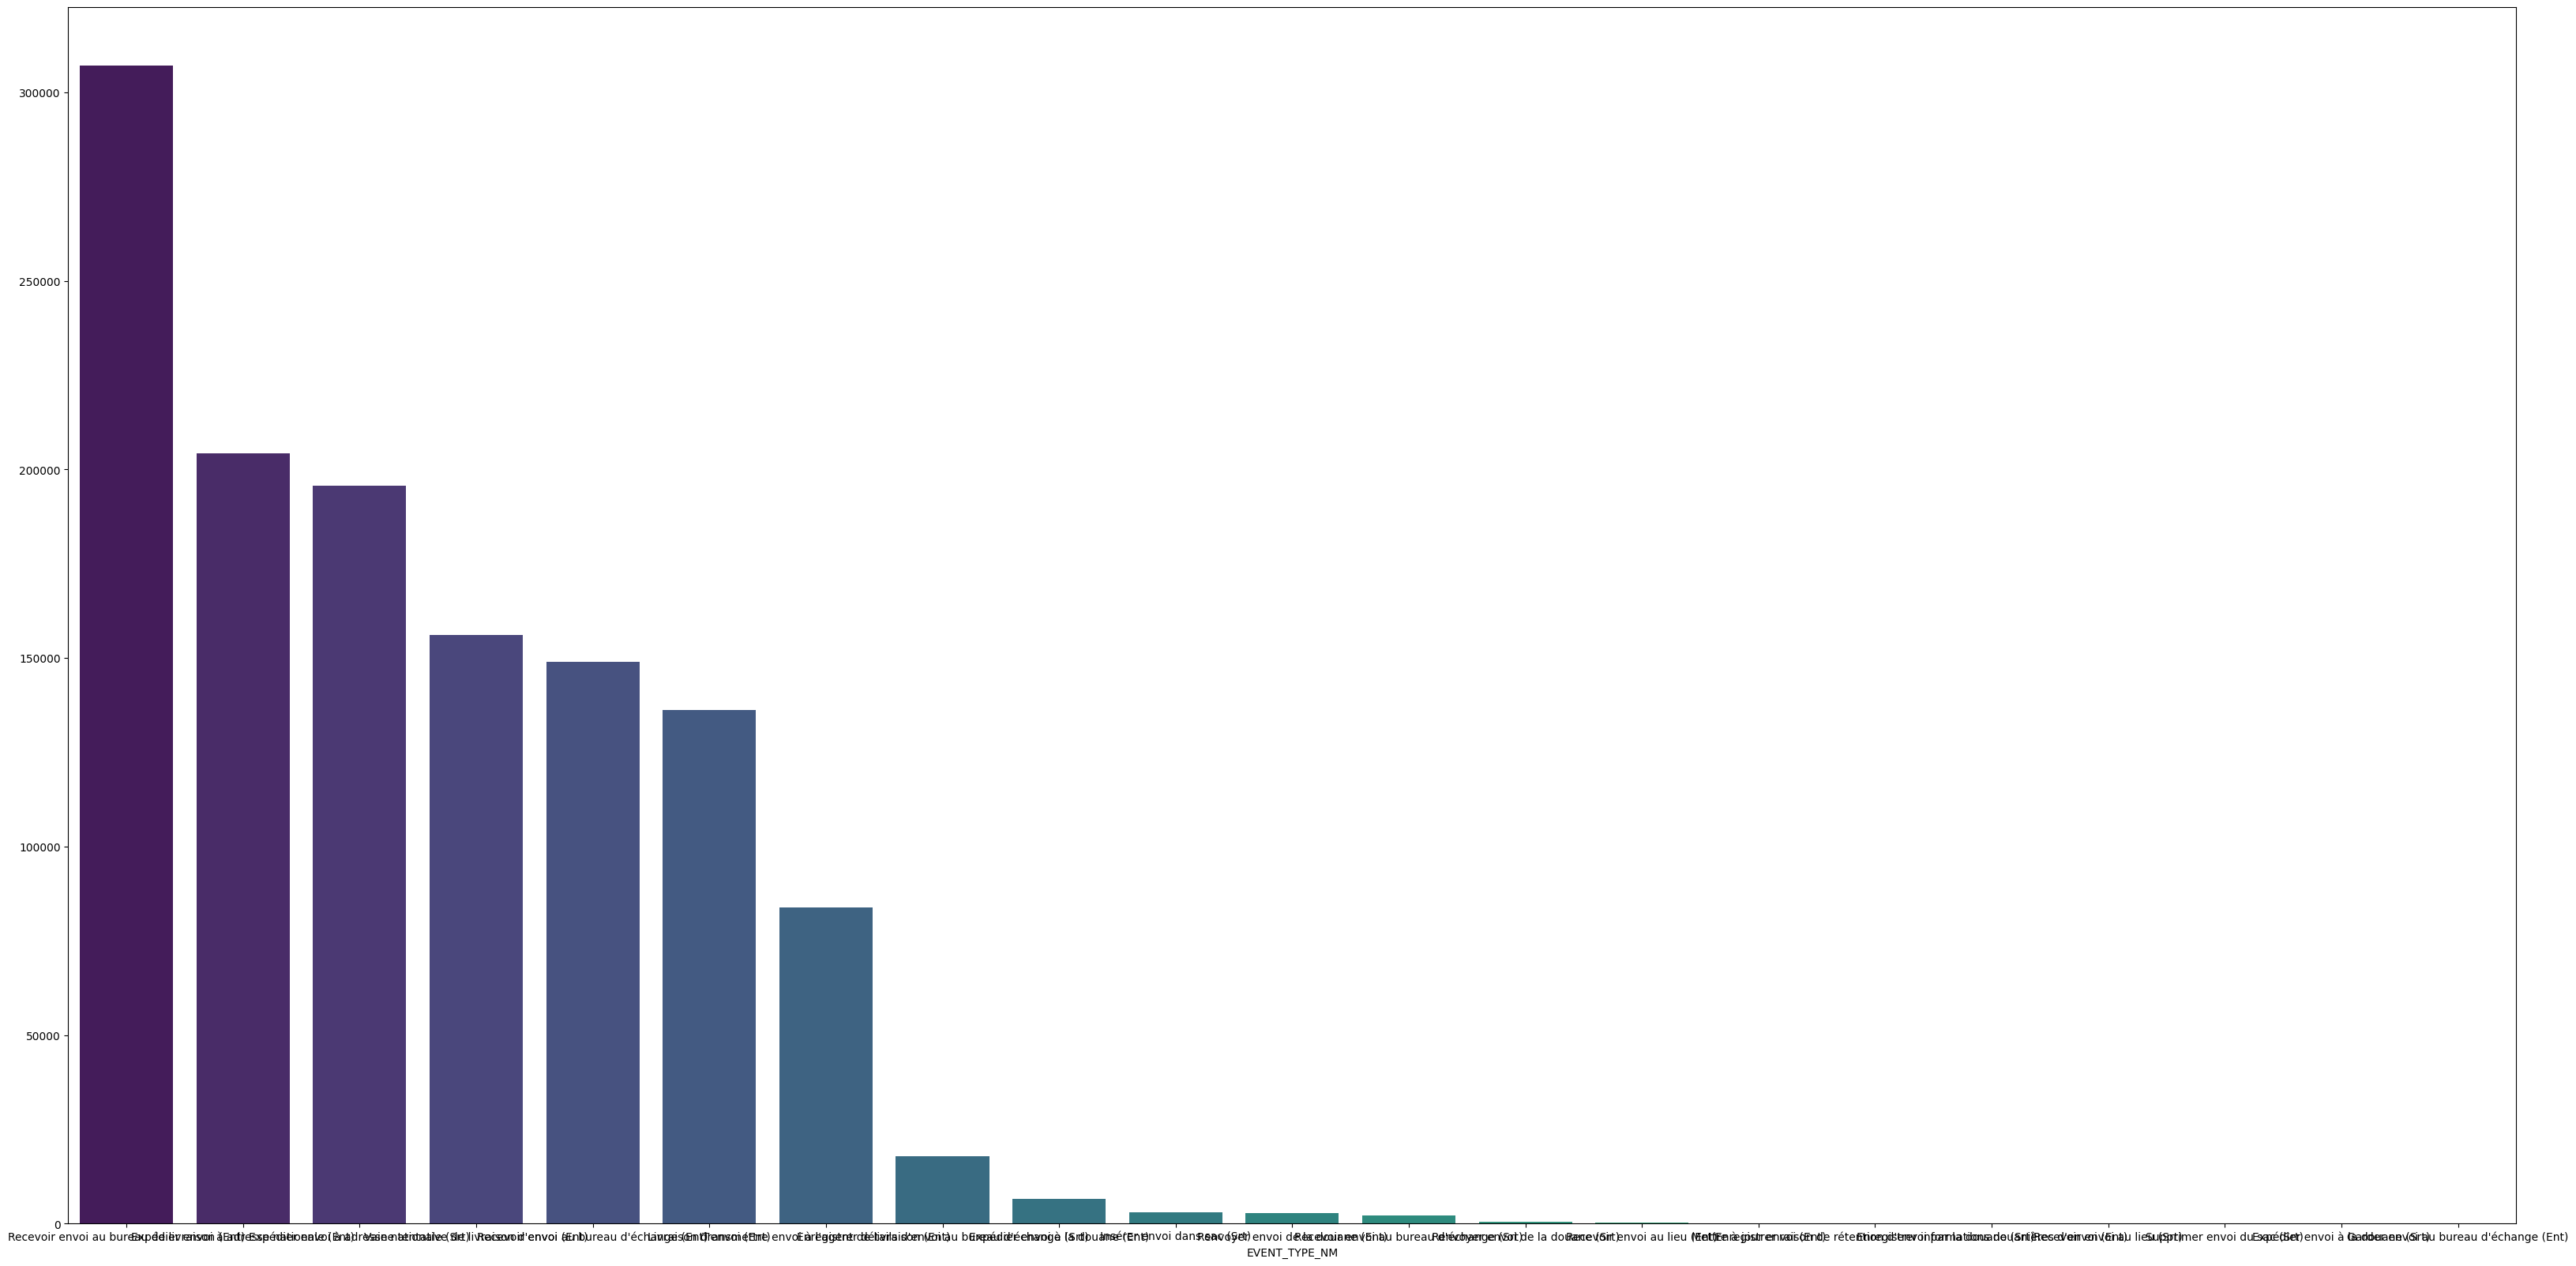

In [11]:

# Count the occurrences of each protocol
event_type = df['EVENT_TYPE_NM'].value_counts()

print(event_type)

# Visualize the counts of each protocol
plt.figure(figsize=(40, 20))
sns.barplot(x=event_type.index, y=event_type.values, palette='viridis')
plt.show()

In [12]:

# Count the occurrences of each protocol
proto_counts = df['établissement_postal'].value_counts()

print(proto_counts)


établissement_postal
ALGER COLIS POSTAUX          171861
ALGER GARE                   166141
CONSTANTINE GARE              41882
CONSTANTINE COLIS POSTAUX     37594
CTR CHLEF                     32998
                              ...  
EL HAMRA                          1
M SILA-UNIVERSITE                 1
OULED-SIDI-BRAHIM                 1
AIN TLETAT                        1
Agence EMS SILA                   1
Name: count, Length: 3228, dtype: int64


In [13]:
# Count the occurrences of each protocol
proto_counts = df['next_établissement_postal'].value_counts()

print(proto_counts)



next_établissement_postal
ALGER GARE                   46965
ORAN COLIS POSTAUX           19755
CONSTANTINE COLIS POSTAUX    18815
CTR CHLEF                    15706
CDD SETIF                    14040
                             ...  
TIOUT                            1
TIT                              1
AIT IMGHOUR                      1
EL WIFAK                         1
ZEKRI                            1
Name: count, Length: 3034, dtype: int64


In [14]:
# Rows whose RECPTCL_FID is not NaN
rec_present = df[df["RECPTCL_FID"].notna()]

# Show the first five
rec_present.head()


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,SGSINBDZALGDAUR40346008010089,RB332092491SG,Recevoir envoi au bureau d'échange (Ent),2024-02-13 08:54:52.243,ALGER GARE,30,NaN
1,SGSINBDZALGDAUR40346008010089,RB332092491SG,Vaine tentative de livraison d'envoi (Ent),2024-02-24 13:34:21.570,BOUHANCHE-BENI-AHMED,36,NaN
2,SGSINBDZALGDAUR40346008010089,RB332110646SG,Expédier envoi à adresse nationale (Ent),2024-02-14 08:48:09.883,ALGER GARE,35,MAHELMA
3,SGSINBDZALGDAUR40346008010089,RB332110646SG,Livraison d'envoi (Ent),2024-02-17 09:02:06.907,MAHELMA,37,NaN
4,SGSINBDZALGDAUR40346008010089,RB332113302SG,Expédier envoi à adresse nationale (Ent),2024-02-13 09:47:24.320,ALGER COLIS POSTAUX,35,ALGER GARE


In [15]:
# 1️⃣  Make sure the column is treated as text (protects against NaNs)
fid = df["MAILITM_FID"].astype("string")

# 2️⃣  Boolean mask: True if both trailing characters are letters (A-Z / a-z)
two_letter_suffix = fid.str[-2:].str.isalpha()

# --- Quick sanity check
print(two_letter_suffix.value_counts(dropna=False))
# True  : rows where the code ends in letters (e.g. "ES")
# False : rows where it ends in digits or something else
# <NA>  : rows where MAILITM_FID itself is missing


MAILITM_FID
True    1265367
Name: count, dtype: Int64


In [18]:
bad_suffix = df[~two_letter_suffix & fid.notna()]

print(f"Bad rows: {len(bad_suffix):,}")
bad_suffix.head()   # peek at the first few offenders



Bad rows: 0


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal


In [13]:
# Build the “good suffix” mask once
suffix_ok = (
    df["MAILITM_FID"]
      .astype("string")
      .str[-2:]
      .str.isalpha()
      .fillna(False)          # treat missing IDs as bad
)

df = df[suffix_ok]

# Quick confirmation
print(f"Rows left: {len(df):,}")
df.head()


Rows left: 10,103,602


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,NaN,CC021659473ES,Insérer envoi dans sac (Srt),2024-01-31 20:11:00.000,ESPAGNE,8,NaN
1,NaN,CC021662747ES,Réception d'envoi du client (Srt),2024-01-31 12:31:00.000,ESPAGNE,1,NaN
2,NaN,CC021662747ES,Insérer envoi dans sac (Srt),2024-02-05 12:46:00.000,ESPAGNE,8,NaN
3,NaN,CC021663328ES,Réception d'envoi du client (Srt),2024-01-31 13:51:00.000,ESPAGNE,1,NaN
4,NaN,CC021663328ES,Insérer envoi dans sac (Srt),2024-02-01 12:32:00.000,ESPAGNE,8,NaN


In [16]:
df['id'] = df["MAILITM_FID"].str[-2:]
df.head()

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal,id
0,SGSINBDZALGDAUR40346008010089,RB332092491SG,Recevoir envoi au bureau d'échange (Ent),2024-02-13 08:54:52.243,ALGER GARE,30,NaN,SG
1,SGSINBDZALGDAUR40346008010089,RB332092491SG,Vaine tentative de livraison d'envoi (Ent),2024-02-24 13:34:21.570,BOUHANCHE-BENI-AHMED,36,NaN,SG
2,SGSINBDZALGDAUR40346008010089,RB332110646SG,Expédier envoi à adresse nationale (Ent),2024-02-14 08:48:09.883,ALGER GARE,35,MAHELMA,SG
3,SGSINBDZALGDAUR40346008010089,RB332110646SG,Livraison d'envoi (Ent),2024-02-17 09:02:06.907,MAHELMA,37,NaN,SG
4,SGSINBDZALGDAUR40346008010089,RB332113302SG,Expédier envoi à adresse nationale (Ent),2024-02-13 09:47:24.320,ALGER COLIS POSTAUX,35,ALGER GARE,SG


In [17]:

# Count the occurrences of each protocol
proto_counts = df['id'].value_counts()

print(proto_counts)

s = proto_counts


id
SG    1087505
US      58947
TR      46153
SE      35612
TN      21896
       ...   
BF          2
DJ          2
GQ          1
HR          1
TJ          1
Name: count, Length: 68, dtype: int64


In [20]:
# Map the Series index using the country_dict
s.index = s.index.map(lambda code: country_dict.get(code, code))  # Keep unmapped codes as-is
print(s)

id
SINGAPOUR             1087505
ÉTATS-UNIS              58947
TURQUIE                 46153
SUÈDE                   35612
TUNISIE                 21896
                       ...   
BURKINA FASO                2
DJIBOUTI                    2
GUINÉE ÉQUATORIALE          1
CROATIE                     1
TADJIKISTAN                 1
Name: count, Length: 68, dtype: int64


In [21]:
print("Min date:", df["date"].min())
print("Max date:", df["date"].max())

Min date: 2018-11-15 10:27:06.737
Max date: 2025-05-21 15:54:58.333


In [22]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S.%f")
# Sort by ID and date
df = df.sort_values(by=["MAILITM_FID", "date"])

# Calculate time to next step
df["duration_to_next_step"] = df.groupby("MAILITM_FID")["date"].shift(-1) - df["date"]

# Calculate total duration per ID
first_date = df.groupby("MAILITM_FID")["date"].transform("first")
last_date = df.groupby("MAILITM_FID")["date"].transform("last")
df["total_duration"] = last_date - first_date

# Preview the updated dataset
df[["MAILITM_FID", "date", "EVENT_TYPE_NM", "duration_to_next_step", "total_duration"]].head(10)


,MAILITM_FID,date,EVENT_TYPE_NM,duration_to_next_step,total_duration
1120379,CA000020800LY,2022-02-22 09:50:25.897,Recevoir envoi au bureau d'échange (Ent),0 days 00:01:37.313000,5 days 23:39:58.013000
1120376,CA000020800LY,2022-02-22 09:52:03.210,Expédier envoi à adresse nationale (Ent),0 days 00:42:49.187000,5 days 23:39:58.013000
1120377,CA000020800LY,2022-02-22 10:34:52.397,Expédier envoi à adresse nationale (Ent),4 days 23:05:57.876000,5 days 23:39:58.013000
1120380,CA000020800LY,2022-02-27 09:40:50.273,Transmettre envoi à l'agent de livraison (Ent),0 days 23:49:33.637000,5 days 23:39:58.013000
1120378,CA000020800LY,2022-02-28 09:30:23.910,Livraison d'envoi (Ent),NaT,5 days 23:39:58.013000
1217245,CA000086085US,2024-11-30 08:24:22.110,Recevoir envoi au bureau d'échange (Ent),2 days 02:10:56.390000,10 days 23:44:14.180000
1217243,CA000086085US,2024-12-02 10:35:18.500,Expédier envoi à adresse nationale (Srt),0 days 21:40:02.907000,10 days 23:44:14.180000
1217246,CA000086085US,2024-12-03 08:15:21.407,Vaine tentative de livraison d'envoi (Ent),7 days 23:53:14.883000,10 days 23:44:14.180000
1217244,CA000086085US,2024-12-11 08:08:36.290,Livraison d'envoi (Ent),NaT,10 days 23:44:14.180000
1239324,CA000094303US,2024-11-30 08:24:41.623,Recevoir envoi au bureau d'échange (Ent),0 days 02:15:03.810000,4 days 00:23:30.387000


In [23]:
df.to_csv("df_with_durations_07.csv", index=False, encoding='utf-8-sig')

In [ ]:
print("no zero duration", 10103602 - 1712240)

no zervo duration 8391362


In [24]:
# Filter rows where total_duration is NOT zero
zero_duration_df = df[df["total_duration"] == pd.Timedelta(0)]

# Display the first few rows as a check
zero_duration_df.shape


(13785, 10)

In [25]:

# Count the occurrences of each protocol
countries = zero_duration_df['id'].value_counts()

print(countries)


id
SG    11325
US      701
SE      673
TR      638
TN      256
TH       36
UA       28
RU       21
DE       16
FR       16
RO       10
CH        8
NL        7
VA        6
GB        4
BG        4
AL        3
BA        3
AZ        3
PK        3
LY        3
PS        2
AO        2
CN        2
VN        2
TJ        1
GQ        1
BE        1
ES        1
PL        1
BY        1
JP        1
CA        1
HR        1
IE        1
IN        1
PT        1
TG        1
Name: count, dtype: int64


In [26]:
# Map the Series index using the country_dict
countries.index = countries.index.map(lambda code: country_dict.get(code, code))  
print(countries)

id
SINGAPOUR                                   11325
ÉTATS-UNIS                                    701
SUÈDE                                         673
TURQUIE                                       638
TUNISIE                                       256
THAÏLANDE                                      36
UKRAINE                                        28
RUSSIE, FÉDÉRATION DE                          21
ALLEMAGNE                                      16
FRANCE                                         16
ROUMANIE                                       10
SUISSE                                          8
PAYS-BAS                                        7
SAINT-SIÈGE (ÉTAT DE LA CITÉ DU VATICAN)        6
ROYAUME-UNI                                     4
BULGARIE                                        4
ALBANIE                                         3
BOSNIE-HERZÉGOVINE                              3
AZERBAÏDJAN                                     3
PAKISTAN                                       

In [27]:
# Step 1: Count how many times each ID appears
id_counts = zero_duration_df["MAILITM_FID"].value_counts()

# Step 2: Count how many IDs have a specific count
count_of_counts = id_counts.value_counts().sort_index()

print(count_of_counts)


count
1    13785
Name: count, dtype: int64


In [28]:
ids_with_0 = id_counts[id_counts == 1].index
df_with_0 = df[df["MAILITM_FID"].isin(ids_with_0)]
df_with_0.head(20)

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal,id,duration_to_next_step,total_duration
1087584,TGLFWADZALGBACN20003001100139,CA000164931TG,Recevoir envoi au bureau d'échange (Ent),2022-03-20 09:47:14.900,ALGER COLIS POSTAUX,30,NaN,TG,NaT,0 days
1239787,USLAXADZALGBACN50063001900010,CA000631038US,Expédier envoi à adresse nationale (Ent),2025-03-22 10:39:18.700,ALGER COLIS POSTAUX,35,AVION CPX ALGER,US,NaT,0 days
1120861,TRISTBDZALGBBCN20087002100031,CA000635573TR,Recevoir envoi au bureau d'échange (Ent),2022-03-20 08:18:28.757,ALGER COLIS POSTAUX,30,NaN,TR,NaT,0 days
1168570,UAIEVDDZALGBBCN40031001100012,CA460021905UA,Expédier envoi à adresse nationale (Srt),2025-01-06 08:41:27.963,CTR CHLEF,2,TADJENA,UA,NaT,0 days
1238602,USLAXADZALGBACN40178004900075,CB100198133US,Recevoir envoi au bureau d'échange (Ent),2024-07-18 08:15:34.833,ALGER COLIS POSTAUX,30,NaN,US,NaT,0 days
1205918,USJFKADZALGBACN20068010900010,CB131930145US,Expédier envoi à adresse nationale (Ent),2022-04-30 13:02:22.740,ALGER COLIS POSTAUX,35,CTR CHLEF,US,NaT,0 days
1243772,USMIAADZALGBACN20048001900037,CB132098825US,Recevoir envoi au bureau de livraison (Ent),2022-04-09 11:20:08.377,EMS ALGER CPX,32,EMS ALGER CPX,US,NaT,0 days
1252932,USORDADZALGBACN30069002900159,CB166802243US,Expédier envoi à adresse nationale (Ent),2023-08-13 08:21:29.923,ALGER COLIS POSTAUX,35,VISITE DOUANE CPX ALGER,US,NaT,0 days
1253486,USORDADZALGBACN30119002900178,CB166951018US,Recevoir envoi au bureau d'échange (Ent),2023-10-07 08:51:43.177,ALGER COLIS POSTAUX,30,NaN,US,NaT,0 days
1254804,USORDADZALGBACN40007002900039,CB167219983US,Expédier envoi à adresse nationale (Ent),2024-02-06 09:07:52.870,ALGER COLIS POSTAUX,35,CDD TIPAZA,US,NaT,0 days


In [29]:

# Count the occurrences of each protocol
event_type = df_with_0['EVENT_TYPE_NM'].value_counts()

print(event_type)



EVENT_TYPE_NM
Recevoir envoi au bureau d'échange (Ent)                       3219
Expédier envoi à adresse nationale (Ent)                       2236
Recevoir envoi au bureau de livraison (Ent)                    2147
Livraison d'envoi (Ent)                                        1515
Expédier envoi à la douane (Ent)                               1424
Expédier envoi à adresse nationale (Srt)                       1348
Vaine tentative de livraison d'envoi (Ent)                     1022
Transmettre envoi à l'agent de livraison (Ent)                  526
Renvoyer envoi de la douane (Ent)                               158
Insérer envoi dans sac (Srt)                                     82
Recevoir envoi au bureau d'échange (Srt)                         52
Enregistrer détails d'envoi au bureau d'échange (Srt)            49
Enregistrer raison de rétention d'envoi par la douane (Srt)       3
Renvoyer envoi de la douane (Srt)                                 2
Recevoir envoi au lieu (Ent)      